In [1]:
# Imports
import mindspore
import mindspore as ms
from mindspore import nn, context, Tensor, ops
from mindspore import dtype as mstype
import mindspore.dataset as ds
import mindspore.dataset.transforms as C
import mindspore.dataset.vision as vision
import mindspore.nn.probability.distribution as msd
import numpy as np
from mindspore.dataset.transforms import Compose
context.set_context(device_target='CPU')
batch_size = 128

class Encoder(nn.Cell):
    def __init__(self, D_in, H, latent_size):
        super(Encoder, self).__init__()
        self.linear1 = nn.Dense(D_in, H)
        self.linear2 = nn.Dense(H, latent_size)
        self.linear3 = nn.Dense(H, latent_size)
        self.relu = nn.ReLU()

    def construct(self, x):
        x = x.reshape(batch_size, -1)
        x = self.linear1(x)
        x = self.relu(x)
        mu = self.linear2(x)
        sigma = self.linear3(x)
        return mu, sigma


class Decoder(nn.Cell):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = nn.Dense(D_in, H)
        self.linear2 = nn.Dense(H, D_out)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        x = self.relu(self.linear1(x))
        return self.sigmoid(self.linear2(x))
class VAE(nn.Cell):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.n = msd.Normal(0.0, 1.0)
    def construct(self, x):
        mu, std = self.encoder(x)
        z = self.sample(mu, std)
        return self.decoder(z), mu, std

    def sample(self, mu, std):
        std = ops.exp(0.5 * std)
        eps = self.n.sample(std.shape)
        z = mu + eps * std
        return z

def kl_loss(shape, mean, std):
    loss = 0.5 * (
                1 + 2 * std - mean ** 2 - ms.ops.Exp()(std)**2).sum()
    return loss

class VAELoss(mindspore.nn.Cell):
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.loss_fn = mindspore.nn.BCEWithLogitsLoss()

    def construct(self, x):
        predict, mean, std = self.net(x)
        klloss = kl_loss(predict.shape[0], mean, std)
        loss = ops.binary_cross_entropy(predict, x.reshape(batch_size, -1), reduction='sum')
        return loss - klloss



In [2]:
num_epochs = 50
learning_rate = 0.001
hidden_size = 512
latent_size = 8
input_dim = 28 * 28

transform = C.Compose([
    vision.ToTensor(),
    ])

mnist_dataset = ds.MnistDataset('./mnist/train')
mnist_dataset = mnist_dataset.map(operations=transform, input_columns=["image"])
dataset = mnist_dataset.batch(batch_size, drop_remainder=True)
iterator = dataset.create_dict_iterator()

encoder = Encoder(input_dim, hidden_size, latent_size)
decoder = Decoder(latent_size, hidden_size, input_dim)

vae = VAE(encoder, decoder)
print(vae)
optimizer = nn.Adam(vae.trainable_params(), learning_rate)
loss_fn = VAELoss(vae)
train_net = mindspore.nn.TrainOneStepCell(loss_fn, optimizer)



VAE<
  (encoder): Encoder<
    (linear1): Dense<input_channels=784, output_channels=512, has_bias=True>
    (linear2): Dense<input_channels=512, output_channels=8, has_bias=True>
    (linear3): Dense<input_channels=512, output_channels=8, has_bias=True>
    (relu): ReLU<>
    >
  (decoder): Decoder<
    (linear1): Dense<input_channels=8, output_channels=512, has_bias=True>
    (linear2): Dense<input_channels=512, output_channels=784, has_bias=True>
    (relu): ReLU<>
    (sigmoid): Sigmoid<>
    >
  (n): Normal<mean = 0.0, standard deviation = 1.0>
  >


In [ ]:
from tqdm import tqdm
train_net.set_train()
for i in range(num_epochs):
    for data in tqdm(iterator):
        loss = train_net(data['image'])
    print('step {}'.format(i), loss)

468it [00:59,  7.83it/s]
1it [00:00,  7.83it/s]

step 0 22275.52


468it [00:57,  8.15it/s]
1it [00:00,  8.16it/s]

step 1 18724.945


468it [00:57,  8.21it/s]
1it [00:00,  8.39it/s]

step 2 18001.623


468it [00:57,  8.21it/s]
1it [00:00,  8.18it/s]

step 3 17401.371


468it [00:57,  8.14it/s]
1it [00:00,  8.11it/s]

step 4 16955.8


468it [00:56,  8.31it/s]
1it [00:00,  8.37it/s]

step 5 16819.031


468it [00:57,  8.18it/s]
1it [00:00,  7.67it/s]

step 6 15996.912


468it [00:57,  8.15it/s]
1it [00:00,  8.35it/s]

step 7 15904.043


468it [00:57,  8.20it/s]
1it [00:00,  8.33it/s]

step 8 16238.233


468it [00:57,  8.15it/s]
1it [00:00,  7.50it/s]

step 9 16221.535


468it [00:55,  8.40it/s]
1it [00:00,  8.54it/s]

step 10 16206.09


468it [00:55,  8.40it/s]
1it [00:00,  8.60it/s]

step 11 16819.361


468it [00:55,  8.41it/s]
1it [00:00,  8.55it/s]

step 12 16785.748


468it [00:56,  8.32it/s]
1it [00:00,  8.32it/s]

step 13 16440.379


468it [00:56,  8.24it/s]
1it [00:00,  8.44it/s]

step 14 16740.123


468it [00:56,  8.33it/s]
1it [00:00,  8.42it/s]

step 15 15817.041


468it [00:56,  8.23it/s]
1it [00:00,  8.09it/s]

step 16 16496.55


468it [00:56,  8.28it/s]
1it [00:00,  8.54it/s]

step 17 15851.519


468it [00:56,  8.30it/s]
1it [00:00,  8.25it/s]

step 18 15166.6


468it [00:56,  8.22it/s]
1it [00:00,  8.05it/s]

step 19 15376.341


468it [00:57,  8.11it/s]
1it [00:00,  8.35it/s]

step 20 16462.066


468it [00:56,  8.32it/s]
1it [00:00,  8.47it/s]

step 21 15838.001


468it [00:55,  8.36it/s]
1it [00:00,  8.59it/s]

step 22 15840.223


468it [00:57,  8.21it/s]
1it [00:00,  8.26it/s]

step 23 16110.936


468it [00:57,  8.20it/s]
1it [00:00,  8.25it/s]

step 24 15290.582


468it [00:56,  8.22it/s]
1it [00:00,  8.38it/s]

step 25 16234.644


468it [00:56,  8.24it/s]
1it [00:00,  8.32it/s]

step 26 15888.995


468it [00:55,  8.43it/s]
1it [00:00,  8.40it/s]

step 27 15178.535


468it [00:56,  8.24it/s]
1it [00:00,  8.49it/s]

step 28 16245.202


291it [00:34,  8.45it/s]

In [5]:
test_dataset = ds.MnistDataset('./mnist/test')
test_dataset = test_dataset.map(operations=transform)
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)
test_iterator = test_dataset.create_dict_iterator()

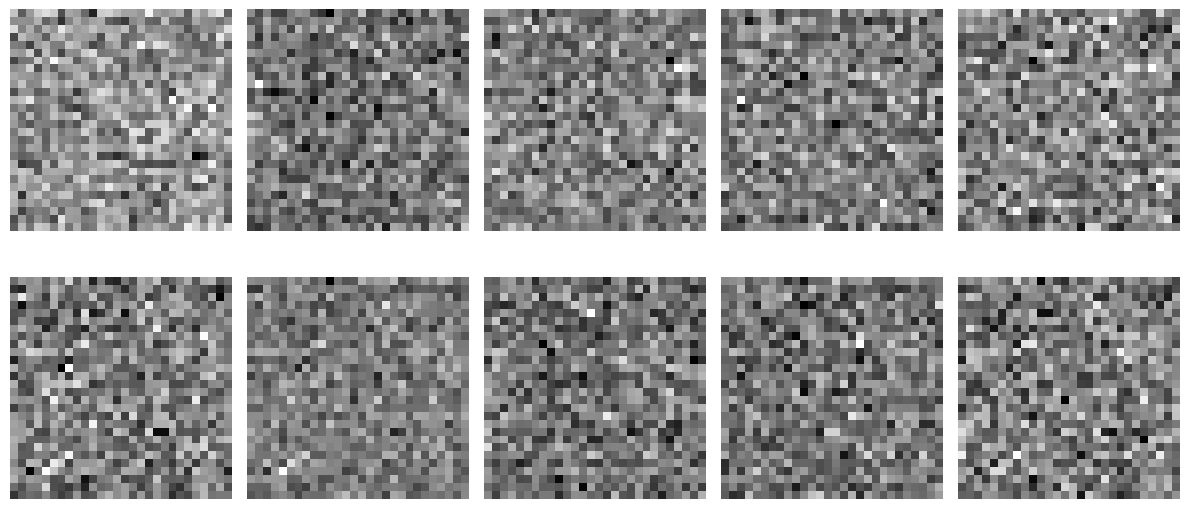

In [6]:
import matplotlib.pyplot as plt

# 加载MNIST数据集
test = vae.decoder(ops.normal((128, 8), mindspore.Tensor(0), mindspore.Tensor(1)))
# 随机选择一些图像
num_images = 10

# 创建一个2x5的子图
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

# 可视化图像
for i in range(10):
    image = np.squeeze(test[i].reshape(28, 28).numpy())  # 去除额外的维度
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
